# Objective

This example implements the Compact Convolutional Transformers   models for image classification, demonstrated on the CIFAR-10 dataset:

# Installation of Packages

In [1]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import cifar10
from tensorflow import keras

# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Data Inspection / Visualization

In [4]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
numRows = x_train.shape[0]
numRows

50000

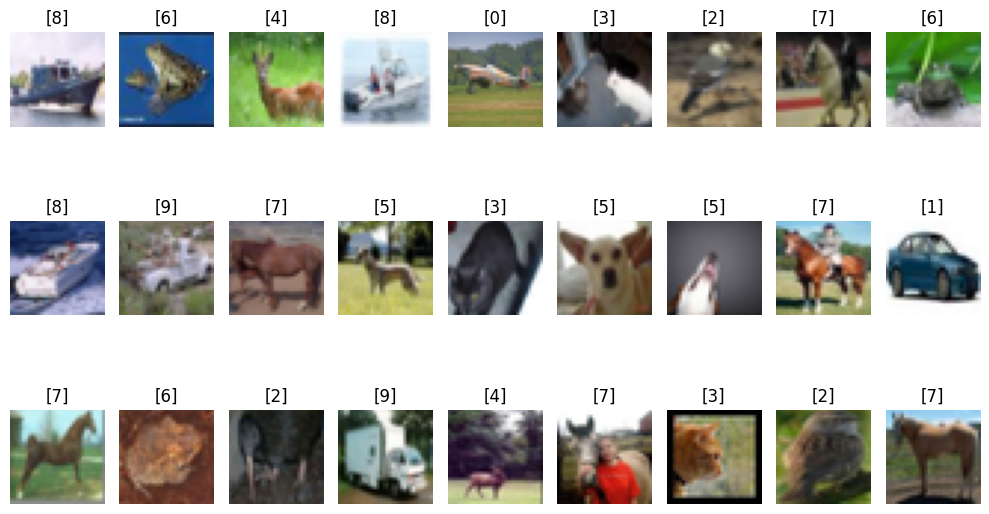

In [6]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
    plt.subplot(4, 9, i+1)
    item = x_train[int(randomIndex[i])]
    plt.imshow(item)
    plt.title(y_train[int(randomIndex[i])])
    plt.axis(False)


plt.tight_layout()

# Data Preprocessing

In [7]:
num_classes = len(np.unique(y_train))
input_shape = (32, 32, 3)

num_classes

10

In [8]:
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

In [9]:
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [10]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


In [11]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

# Data Postprocessing

In [12]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [15]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

In [16]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

In [17]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped

# Model

In [18]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [19]:
cct_model = create_cct_model()

In [20]:
#utils.plot_model(model, show_shapes=True)
#model.summary()

# Training

In [21]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    
    evaluation= model.evaluate(x_test, y_test)

    return history, model, evaluation

In [22]:
history, model, evaluation = run_experiment(cct_model)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.2703 - loss: 2.0831 - top-5-accuracy: 0.7586 - val_accuracy: 0.5182 - val_loss: 1.5354 - val_top-5-accuracy: 0.9414
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5138 - loss: 1.5461 - top-5-accuracy: 0.9392 - val_accuracy: 0.6094 - val_loss: 1.3602 - val_top-5-accuracy: 0.9602
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5969 - loss: 1.3827 - top-5-accuracy: 0.9576 - val_accuracy: 0.6296 - val_loss: 1.3304 - val_top-5-accuracy: 0.9604
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.6383 - loss: 1.2960 - top-5-accuracy: 0.9654 - val_accuracy: 0.6706 - val_loss: 1.2285 - val_top-5-accuracy: 0.9720
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.6789 - loss: 1.2210 - top-5-accuracy: 0.9704 - val_accuracy: 0.6822 - val_loss: 1.2017 - val_top-5-accuracy: 0.9764
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6966 - loss:

# Evaluation

In [23]:
 _, accuracy, top_5_accuracy = evaluation
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Test accuracy: 79.66%
Test top 5 accuracy: 98.44%


In [24]:
def make_plot(metric):
  plt.plot(history.history[metric ])
  plt.plot(history.history['val_'+metric ])
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

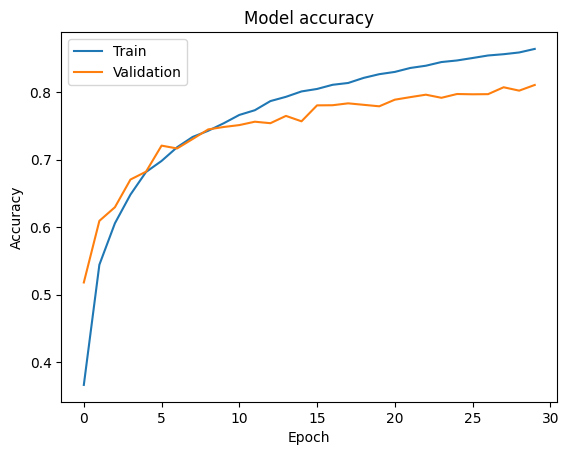

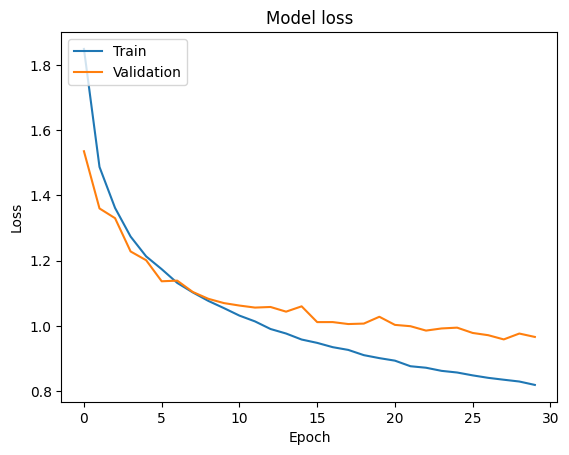

In [25]:
make_plot('accuracy')
make_plot('loss')

# Inference

# Deploy

In [26]:
#model.save("custom_image_classification_model")